# Libraries & Data

In [1]:
# !pip install numpy==1.23.5
# !pip install scikit-learn
# !pip install pandas
# !pip install matplotlib
# !pip install nltk
# !pip install emoji
# !pip install -U keras-tuner
# !pip install tensorflow
# !pip install kaggle
# !pip install -U spacy
# !pip install gensim
#
# !rm -r KT_dir_2

In [2]:
import nltk
import tensorflow as tf
import keras_tuner as kt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os, json, re, time, emoji, kaggle
import gensim.downloader as api


from nltk.tag.perceptron import PerceptronTagger
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet, stopwords

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_recall_curve,
    auc,
    accuracy_score,
    ConfusionMatrixDisplay,
    f1_score,
    recall_score,
    precision_score,
    classification_report,
)
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

from spacy.lang.en.stop_words import STOP_WORDS

In [3]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("averaged_perceptron_tagger")

[nltk_data] Downloading package punkt to /Users/antonal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/antonal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/antonal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/antonal/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/antonal/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [4]:
# Ensure the Kaggle directory exists
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)

# Copy kaggle.json to the right location if it is not already there
# Uncomment and modify the below lines if you need to place your kaggle.json file in the right directory
# import shutil
# shutil.copy('path_to_your_kaggle.json', os.path.expanduser('~/.kaggle/kaggle.json'))

# Download the dataset using Kaggle API
!kaggle datasets download -d jp797498e/twitter-entity-sentiment-analysis

Dataset URL: https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis
License(s): CC0-1.0
 50%|███████████████████                   | 1.00M/1.99M [00:00<00:00, 2.11MB/s]
100%|██████████████████████████████████████| 1.99M/1.99M [00:00<00:00, 3.55MB/s]


In [7]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username": "{username}", "key": "{key}"}

with open("/Users/antonal/.kaggle/kaggle.json", "w") as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

mkdir: /Users/antonal/.kaggle: File exists


In [8]:
kaggle.api.authenticate()
kaggle.api.competition_download_files("twitter-sentiment-analysis2")

In [9]:
!unzip twitter-sentiment-analysis2.zip

Archive:  twitter-sentiment-analysis2.zip
  inflating: test.csv                
  inflating: train.csv               


### Initialise dataset

In [5]:
# Read the CSV file 'train.csv', selecting only the 'Sentiment' and 'SentimentText' columns.
df_tweet_sentiment = pd.read_csv(
    "./train.csv",
    encoding="ISO-8859-1",
    usecols=["Sentiment", "SentimentText"],
    index_col=False,
)

# Filtering the DataFrame to get the first 5000 rows where the sentiment is 0 (negative)
df_negative_tweets = df_tweet_sentiment[df_tweet_sentiment["Sentiment"] == 0].head(5000)

# Filtering the DataFrame to get the first 5000 rows where the sentiment is 1 (positive)
df_positive_tweets = df_tweet_sentiment[df_tweet_sentiment["Sentiment"] == 1].head(5000)

# Concatenate the two filtered DataFrames into a single DataFrame
df_tweet_sentiment = pd.concat([df_negative_tweets, df_positive_tweets])

# Shuffle the concatenated DataFrame randomly and reset the index
df_tweet_sentiment = df_tweet_sentiment.sample(frac=1).reset_index(drop=True)
df_tweet_sentiment

,Sentiment,SentimentText
0,1,"#Charlotte NC Rides i need a ride to pgh,pa! (..."
1,1,&quot;Invisible Bow and Arrow : Free&quot; - ...
2,0,i have a cold!
3,0,#dontyouhate when your hungry but u dnt know w...
4,1,Goood Morning Twittz. I'm in an Extremely goo...
...,...,...
9995,1,#followfriday @Annjj cos she tastes like cher...
9996,0,one of my cats is very ill after reacting bad...
9997,0,Forgot about them science exams tbh (N)
9998,0,this bit in camp rock always makes me upset.....


In [6]:
# Initialize a WordNetLemmatizer, which is used to reduce words to their base or root form, e.g., (churches -> church, abaci -> abacus)
lemmatizer = WordNetLemmatizer()

# Initialize a PerceptronTagger, which is a part-of-speech tagger used to label words with their corresponding parts of speech
tagger = PerceptronTagger()

# Initialize a TweetTokenizer, which is specifically designed to handle tokenizing tweets (short text with special characters and emoticons)
tweet_wt = TweetTokenizer()

# Preprocess dataset

In [7]:
# Lemmatization helper function
def nltk_pos_tagger(nltk_tag):
    if nltk_tag.startswith("J"):
        return wordnet.ADJ
    elif nltk_tag.startswith("V"):
        return wordnet.VERB
    elif nltk_tag.startswith("N"):
        return wordnet.NOUN
    elif nltk_tag.startswith("R"):
        return wordnet.ADV
    else:
        return None

In [8]:
def replace_special_tokens(sequence):
    # Replace URLs with the token "<url>"
    sequence = re.sub(
        """http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F]
        [0-9a-fA-F]))+""",
        "<url>",
        sequence,
    )

    # Replace mentions (words starting with @) with the token "<user>"
    sequence = re.sub("@\S+", "<user>", sequence)

    # Replace hashtags (words starting with #) with the token "<hashtag>"
    sequence = re.sub("#\S+", "<hashtag>", sequence)

    # Replace numbers (including decimals) with the token "<number>"
    sequence = re.sub("([+-]?([0-9]+([.][0-9]*)?|[.][0-9]+))", "<number>", sequence)

    # Convert emojis to text representation (e.g., 😊 to :smiling_face_with_smiling_eyes:)
    sequence = emoji.demojize(sequence)  # remove emojis

    # Remove emoticons (represented as :word:) from the sequence
    sequence = re.sub(r"\s*:[\w]+", " ", sequence)  # remove emoticons

    # Convert the entire sequence to lowercase
    sequence = sequence.lower()

    return sequence

In [9]:
# Apply the replace_special_tokens function to the 'SentimentText' column to preprocess the text
df_tweet_sentiment["processed_text"] = df_tweet_sentiment["SentimentText"].apply(
    replace_special_tokens
)

# Tokenize the processed text using the TweetTokenizer
df_tweet_sentiment["tokenized_text"] = df_tweet_sentiment["processed_text"].apply(
    lambda x: tweet_wt.tokenize(x)
)

# Tag the tokenized text with part-of-speech tags using the PerceptronTagger
df_tweet_sentiment["text_tags"] = df_tweet_sentiment["tokenized_text"].apply(
    lambda x: tagger.tag(x)
)
df_tweet_sentiment

,Sentiment,SentimentText,processed_text,tokenized_text,text_tags
0,1,"#Charlotte NC Rides i need a ride to pgh,pa! (...","<hashtag> nc rides i need a ride to pgh,pa! (h...","[<hashtag>, nc, rides, i, need, a, ride, to, p...","[(<hashtag>, JJ), (nc, NN), (rides, NNS), (i, ..."
1,1,&quot;Invisible Bow and Arrow : Free&quot; - ...,&quot;invisible bow and arrow : free&quot; - ...,"["", invisible, bow, and, arrow, :, free, "", -,...","[("", NN), (invisible, JJ), (bow, NN), (and, CC..."
2,0,i have a cold!,i have a cold!,"[i, have, a, cold, !]","[(i, NNS), (have, VBP), (a, DT), (cold, NN), (..."
3,0,#dontyouhate when your hungry but u dnt know w...,<hashtag> when your hungry but u dnt know what...,"[<hashtag>, when, your, hungry, but, u, dnt, k...","[(<hashtag>, NN), (when, WRB), (your, PRP$), (..."
4,1,Goood Morning Twittz. I'm in an Extremely goo...,goood morning twittz. i'm in an extremely goo...,"[goood, morning, twittz, ., i'm, in, an, extre...","[(goood, NN), (morning, NN), (twittz, NN), (.,..."
...,...,...,...,...,...
9995,1,#followfriday @Annjj cos she tastes like cher...,<hashtag> <user> cos she tastes like cherry c...,"[<hashtag>, <user>, cos, she, tastes, like, ch...","[(<hashtag>, JJ), (<user>, NN), (cos, NN), (sh..."
9996,0,one of my cats is very ill after reacting bad...,one of my cats is very ill after reacting bad...,"[one, of, my, cats, is, very, ill, after, reac...","[(one, CD), (of, IN), (my, PRP$), (cats, NNS),..."
9997,0,Forgot about them science exams tbh (N),forgot about them science exams tbh (n),"[forgot, about, them, science, exams, tbh, (, ...","[(forgot, NNS), (about, IN), (them, PRP), (sci..."
9998,0,this bit in camp rock always makes me upset.....,this bit in camp rock always makes me upset.....,"[this, bit, in, camp, rock, always, makes, me,...","[(this, DT), (bit, NN), (in, IN), (camp, NN), ..."


In [10]:
# Function to lemmatize a sequence of tokens with POS tags
def lemma(sequence):
    return [
        lemmatizer.lemmatize(token, pos=nltk_pos_tagger(pos_tag))
        if nltk_pos_tagger(pos_tag) != None
        else lemmatizer.lemmatize(token)
        for token, pos_tag in sequence
    ]

In [11]:
# Apply the lemma function to the 'text_tags' column of the dataframe
# 'text_tags' is assumed to be a list of (token, pos_tag) tuples for each tweet
df_tweet_sentiment["lemmatized_text"] = df_tweet_sentiment["text_tags"].apply(
    lambda x: lemma(x)
)

In [12]:
# Apply a lambda function to the 'lemmatized_text' column of the dataframe
# This lambda function joins the list of lemmatized tokens into a single string
# Each token is separated by a space
df_tweet_sentiment["lemmatized_text_joined"] = df_tweet_sentiment[
    "lemmatized_text"
].apply(lambda x: " ".join(x))
df_tweet_sentiment

,Sentiment,SentimentText,processed_text,tokenized_text,text_tags,lemmatized_text,lemmatized_text_joined
0,1,"#Charlotte NC Rides i need a ride to pgh,pa! (...","<hashtag> nc rides i need a ride to pgh,pa! (h...","[<hashtag>, nc, rides, i, need, a, ride, to, p...","[(<hashtag>, JJ), (nc, NN), (rides, NNS), (i, ...","[<hashtag>, nc, ride, i, need, a, ride, to, pg...","<hashtag> nc ride i need a ride to pgh , pa ! ..."
1,1,&quot;Invisible Bow and Arrow : Free&quot; - ...,&quot;invisible bow and arrow : free&quot; - ...,"["", invisible, bow, and, arrow, :, free, "", -,...","[("", NN), (invisible, JJ), (bow, NN), (and, CC...","["", invisible, bow, and, arrow, :, free, "", -,...",""" invisible bow and arrow : free "" - <url> <ha..."
2,0,i have a cold!,i have a cold!,"[i, have, a, cold, !]","[(i, NNS), (have, VBP), (a, DT), (cold, NN), (...","[i, have, a, cold, !]",i have a cold !
3,0,#dontyouhate when your hungry but u dnt know w...,<hashtag> when your hungry but u dnt know what...,"[<hashtag>, when, your, hungry, but, u, dnt, k...","[(<hashtag>, NN), (when, WRB), (your, PRP$), (...","[<hashtag>, when, your, hungry, but, u, dnt, k...",<hashtag> when your hungry but u dnt know what...
4,1,Goood Morning Twittz. I'm in an Extremely goo...,goood morning twittz. i'm in an extremely goo...,"[goood, morning, twittz, ., i'm, in, an, extre...","[(goood, NN), (morning, NN), (twittz, NN), (.,...","[goood, morning, twittz, ., i'm, in, an, extre...",goood morning twittz . i'm in an extremely goo...
...,...,...,...,...,...,...,...
9995,1,#followfriday @Annjj cos she tastes like cher...,<hashtag> <user> cos she tastes like cherry c...,"[<hashtag>, <user>, cos, she, tastes, like, ch...","[(<hashtag>, JJ), (<user>, NN), (cos, NN), (sh...","[<hashtag>, <user>, co, she, taste, like, cher...",<hashtag> <user> co she taste like cherry cola...
9996,0,one of my cats is very ill after reacting bad...,one of my cats is very ill after reacting bad...,"[one, of, my, cats, is, very, ill, after, reac...","[(one, CD), (of, IN), (my, PRP$), (cats, NNS),...","[one, of, my, cat, be, very, ill, after, react...",one of my cat be very ill after react badly wi...
9997,0,Forgot about them science exams tbh (N),forgot about them science exams tbh (n),"[forgot, about, them, science, exams, tbh, (, ...","[(forgot, NNS), (about, IN), (them, PRP), (sci...","[forgot, about, them, science, exam, tbh, (, n...",forgot about them science exam tbh ( n )
9998,0,this bit in camp rock always makes me upset.....,this bit in camp rock always makes me upset.....,"[this, bit, in, camp, rock, always, makes, me,...","[(this, DT), (bit, NN), (in, IN), (camp, NN), ...","[this, bit, in, camp, rock, always, make, me, ...",this bit in camp rock always make me upset .. ...


In [13]:
x_train, x_test, y_train, y_test = train_test_split(
    df_tweet_sentiment["lemmatized_text_joined"],
    df_tweet_sentiment["Sentiment"],
    test_size=0.2,
    random_state=23828748,
)
print("Training texts:", len(x_train))
print("Testing texts:", len(x_test))

Training texts: 8000
Testing texts: 2000


# TF-Idf Vectorizer

In [14]:
# Use unigram & bi-gram tf*idf features
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    max_features=5000,
    sublinear_tf=True,
    stop_words=stopwords.words("english"),
)

In [15]:
# Fit Vectorizer on train data
# Transform on all data (train - test)
x_train_tfidf = vectorizer.fit_transform(x_train)
x_test_tfidf = vectorizer.transform(x_test)

print(vectorizer.get_feature_names_out()[:10])

['aahh' 'aay' 'abc' 'ability' 'abit' 'able' 'able get' 'able go'
 'able make' 'able see']


In [19]:
print("Shape of training data: {}".format(x_train_tfidf.shape))
print("Shape of test data: {}\n".format(x_test_tfidf.shape))

Shape of training data: (8000, 5000)
Shape of test data: (2000, 5000)



In [20]:
# sparse matrix --> Saves only the cells where tf*idf is not zero
print(type(x_test_tfidf))
print(x_test_tfidf[0, :])

<class 'scipy.sparse._csr.csr_matrix'>
  (0, 1752)	0.16906688632894443
  (0, 1896)	0.6310284849412695
  (0, 2828)	0.3704069713692927
  (0, 3319)	0.6603166775879509


# Baseline

In [21]:
# Train
# The dummy classifier always predicts the 'most frequent' class
baseline = DummyClassifier(strategy="most_frequent")
start_time = time.time()
baseline.fit(x_train_tfidf, y_train)
print("Training took: {} seconds \n".format(time.time() - start_time))

Training took: 0.0029239654541015625 seconds 



In [22]:
# Evaluate
predictions = baseline.predict(x_train_tfidf)
score = accuracy_score(y_train, predictions)
print("Train accuracy: {:.2f}%".format(score * 100))

predictions_test = baseline.predict(x_test_tfidf)
score = accuracy_score(y_test, predictions_test)
print("Test accuracy: {:.2f}% \n".format(score * 100))

print("#Class 0 in Train dataset:", np.where(y_train == 0)[0].shape)
print("#Class 1 in Train dataset:", np.where(y_train == 1)[0].shape)

Train accuracy: 50.09%
Test accuracy: 49.65% 

#Class 0 in Train dataset: (3993,)
#Class 1 in Train dataset: (4007,)


In [23]:
print("Classification Report for TRAIN data set:")
print(classification_report(y_train, predictions))

Classification Report for TRAIN data set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3993
           1       0.50      1.00      0.67      4007

    accuracy                           0.50      8000
   macro avg       0.25      0.50      0.33      8000
weighted avg       0.25      0.50      0.33      8000



/Users/antonal/ta2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/antonal/ta2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/antonal/ta2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [24]:
print("Classification Report for TEST data set:")
print(classification_report(y_test, predictions_test))

Classification Report for TEST data set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1007
           1       0.50      1.00      0.66       993

    accuracy                           0.50      2000
   macro avg       0.25      0.50      0.33      2000
weighted avg       0.25      0.50      0.33      2000



/Users/antonal/ta2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/antonal/ta2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/antonal/ta2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Confusion Matrix for test data:


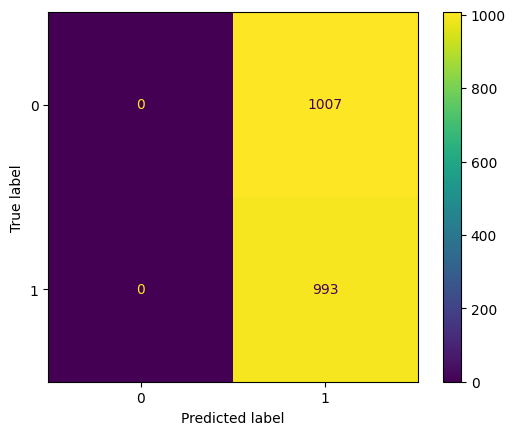

In [25]:
print("\nConfusion Matrix for test data:")
ConfusionMatrixDisplay.from_estimator(
    baseline, x_test_tfidf, y_test, values_format=".0f"
)

# Logistic Regression

In [26]:
# Cross Validation Logistic Regression
# Fit the model with CV
log_cv = LogisticRegressionCV(
    cv=3, Cs=8, random_state=2, penalty="l2", solver="liblinear"
).fit(x_train_tfidf, y_train)
# Score
log_cv.score(x_test_tfidf, y_test)

0.747

In [27]:
predictions = log_cv.predict(x_train_tfidf)
score = f1_score(y_train, predictions)

In [28]:
predictions_test = log_cv.predict(x_test_tfidf)
score_pred = f1_score(y_test, predictions_test)

In [29]:
print("Train f1-score: {:.2f}% \n".format(score * 100))
print("Classification Report for TRAIN data set:")
print(classification_report(y_train, predictions))

Train f1-score: 89.69% 

Classification Report for TRAIN data set:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      3993
           1       0.90      0.90      0.90      4007

    accuracy                           0.90      8000
   macro avg       0.90      0.90      0.90      8000
weighted avg       0.90      0.90      0.90      8000



In [30]:
print("Test f1-score: {:.2f}% \n".format(score_pred * 100))
print("Classification Report for TEST data set:")
print(classification_report(y_test, predictions_test))

Test f1-score: 74.44% 

Classification Report for TEST data set:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75      1007
           1       0.75      0.74      0.74       993

    accuracy                           0.75      2000
   macro avg       0.75      0.75      0.75      2000
weighted avg       0.75      0.75      0.75      2000




Confusion Matrix for test data:


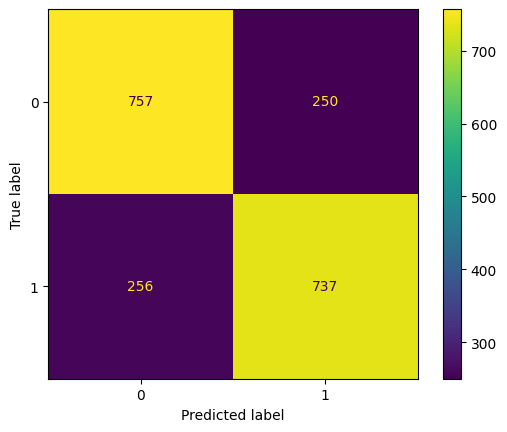

In [31]:
print("\nConfusion Matrix for test data:")
ConfusionMatrixDisplay.from_estimator(log_cv, x_test_tfidf, y_test, values_format=".0f")

# MLP with TF-Idf Vectorizer


In [36]:
X_train_new, X_val, y_train_new, y_val = train_test_split(
    x_train, y_train, test_size=1 / 8, random_state=23828748
)

In [37]:
# Convert with Keras
y_train_1_hot = tf.keras.utils.to_categorical(
    y_train_new, num_classes=len(y_train_new.unique())
)  # 7000

y_val_1_hot = tf.keras.utils.to_categorical(
    y_val, num_classes=len(y_val.unique())
)  # 1000

y_test_1_hot = tf.keras.utils.to_categorical(
    y_test, num_classes=len(y_test.unique())
)  # 2000


y_train_old_1_hot = tf.keras.utils.to_categorical(
    y_train, num_classes=len(y_train.unique())
)  # 8000

# Recalculate the TF-idf features with the new train-val-test set

In [38]:
# Use unigram & bi-gram tf*idf features
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    max_features=5000,
    sublinear_tf=True,
    stop_words=stopwords.words("english"),
)

In [39]:
# Fit Vectorizer on train data
# Transform on all data (train - val - test)
x_train_tfidf_new = vectorizer.fit_transform(X_train_new).toarray()
x_val_tfidf_new = vectorizer.transform(X_val).toarray()
x_test_tfidf_new = vectorizer.transform(x_test).toarray()

## MLP classifier in Keras using tf*idf features

In [41]:
# Define a custom callback class Metrics that inherits from tf.keras.callbacks.Callback
class Metrics(tf.keras.callbacks.Callback):
    # Initialize the class with validation data
    def __init__(self, valid_data):
        # Call the parent class's initializer
        super(Metrics, self).__init__()
        # Store the validation data
        self.validation_data = valid_data

    # This method is called at the end of each epoch
    def on_epoch_end(self, epoch, logs=None):
        # If logs dictionary is not provided, initialize it as an empty dictionary
        logs = logs or {}
        # Predict the output for validation data and take the class with the highest probability
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), -1)
        # Get the actual validation targets
        val_targ = self.validation_data[1]
        # Cast the validation targets to float32 type
        val_targ = tf.cast(val_targ, dtype=tf.float32)
        # If the validation targets are one-hot encoded, convert them to label encoded
        if len(val_targ.shape) == 2 and val_targ.shape[1] != 1:
            val_targ = np.argmax(val_targ, -1)

        # Calculate the weighted F1 score
        _val_f1 = f1_score(val_targ, val_predict, average="weighted")
        # Calculate the weighted recall
        _val_recall = recall_score(val_targ, val_predict, average="weighted")
        # Calculate the weighted precision
        _val_precision = precision_score(val_targ, val_predict, average="weighted")

        # Log the calculated metrics
        logs["val_f1"] = _val_f1
        logs["val_recall"] = _val_recall
        logs["val_precision"] = _val_precision
        # Print the calculated metrics
        print(
            " — val_f1: %f — val_precision: %f — val_recall: %f"
            % (_val_f1, _val_precision, _val_recall)
        )
        return

In [42]:
# Define a Sequential model
model = Sequential()

# Add the first dense (fully connected) layer with 512 units, ReLU activation
# The input dimension is the number of features in the TF-IDF transformed training data
model.add(Dense(512, input_dim=x_train_tfidf_new.shape[1], activation="relu"))

# Add a dropout layer to prevent overfitting by randomly dropping 50% of neurons
model.add(Dropout(0.5))

# Add the second dense layer with 256 units, ReLU activation
model.add(Dense(256, activation="relu"))

# Add another dropout layer with a 50% dropout rate
model.add(Dropout(0.5))

# Add the output layer with softmax activation for multi-class classification
# The number of units is equal to the number of unique classes in the target variable (y_train_new)
model.add(Dense(len(y_train_new.unique()), activation="softmax"))

# Print the summary of the model architecture
print(model.summary())

# Compile the model
# - Loss: categorical cross-entropy (since this is a multi-class classification problem)
# - Optimizer: Adam with a learning rate of 0.001
# - Metrics: categorical accuracy, to monitor classification performance
model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=0.001),
    metrics=[CategoricalAccuracy()],
)

# Create a directory for saving model checkpoints, if it doesn't exist already
if not os.path.exists("./checkpoints"):
    os.makedirs("./checkpoints")

# Define a checkpoint callback to save the best model based on validation F1-score
# - It saves only the weights (`save_weights_only=True`)
# - It saves the best model according to the highest validation F1 score (`monitor="val_f1"`)
checkpoint = ModelCheckpoint(
    "checkpoints/mlp.weights.h5",  # Filepath where weights will be saved
    monitor="val_f1",              # Metric to monitor
    mode="max",                    # Mode to maximize the F1-score
    verbose=2,                     # Verbose level for logging
    save_best_only=True,           # Save only the best model
    save_weights_only=True,        # Save weights instead of the full model
)

# Early stopping callback to stop training if the validation loss doesn't improve for 20 epochs
# - `restore_best_weights=True` ensures the model weights are restored to the best observed state
early_stopping = EarlyStopping(patience=20, verbose=2, restore_best_weights=True)

# Train the model
# - Training data: `x_train_tfidf_new` and one-hot encoded labels `y_train_1_hot`
# - Validation data: `x_val_tfidf_new` and one-hot encoded labels `y_val_1_hot`
# - Batch size: 256
# - Epochs: 100
# - Shuffle the data before each epoch
# - Use the custom metrics, checkpoint, and early stopping as callbacks
history = model.fit(
    x_train_tfidf_new,                        # Training features
    y_train_1_hot,                            # Training labels (one-hot encoded)
    validation_data=(x_val_tfidf_new, y_val_1_hot),  # Validation data
    batch_size=256,                           # Batch size for training
    epochs=100,                               # Maximum number of epochs
    shuffle=True,                             # Shuffle training data each epoch
    callbacks=[
        Metrics(valid_data=(x_val_tfidf_new, y_val_1_hot)),  # Custom metric for F1 score
        checkpoint,                                         # Save best model checkpoint
        early_stopping,                                     # Stop early if no improvement
    ],
)

/Users/antonal/ta2/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │     2,560,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,692,354 (10.27 MB)

 Trainable params: 2,692,354 (10.27 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
 — val_f1: 0.737900 — val_precision: 0.737948 — val_recall: 0.738000

Epoch 1: val_f1 improved from -inf to 0.73790, saving model to checkpoints/mlp.weights.h5
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - categorical_accuracy: 0.5655 - loss: 0.6857 - val_categorical_accuracy: 0.7380 - val_loss: 0.6054 - val_f1: 0.7379 - val_recall: 0.7380 - val_precision: 0.7379
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
 — val_f1: 0.749471 — val_precision: 0.750686 — val_recall: 0.750000

Epoch 2: val_f1 improved from 0.73790 to 0.74947, saving model to checkpoints/mlp.weights.h5
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - categorical_accuracy: 0.7887 - loss: 0.5264 - val_categorical_accuracy: 0.7500 - val_loss: 0.5232 - val_f1: 0.7495 - val_recall: 0.7500 - val_precision: 0.7507
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/stepp - categ
 — val_f1: 0.737900 — val_precision: 0.737948 — val_recall: 0.738000

Epoch 3: val_f1 did not improve from

Visualize Model's Training History

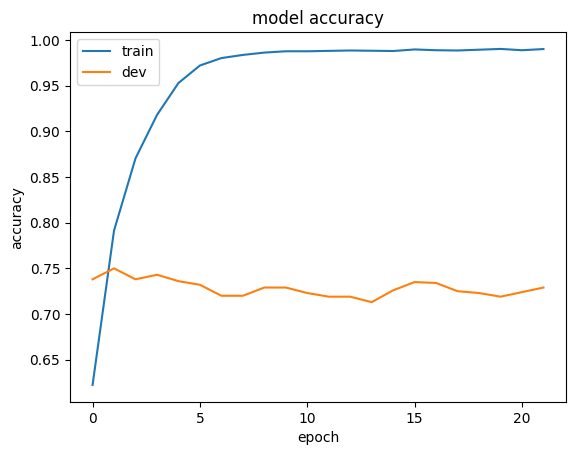

In [43]:
# summarize history for accuracy
plt.plot(history.history["categorical_accuracy"])
plt.plot(history.history["val_categorical_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "dev"], loc="upper left")
plt.show()

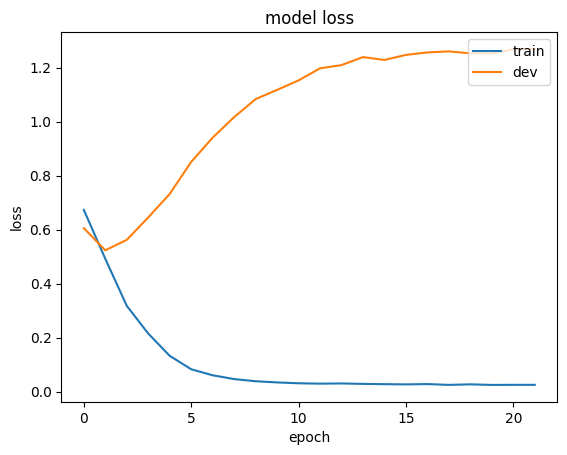

In [44]:
# summarize history for loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "dev"], loc="upper right")
plt.show()

Evaluate performance of tf-idf MLP model

In [45]:
# Define a Sequential model
model = Sequential()

# Add the first dense (fully connected) layer with 512 units and ReLU activation
# The input dimension is the number of features in the TF-IDF transformed training data
model.add(Dense(512, input_dim=x_train_tfidf_new.shape[1], activation="relu"))

# Add the second dense layer with 256 units and ReLU activation
model.add(Dense(256, activation="relu"))

# Add the output layer with softmax activation for multi-class classification
# The number of units is equal to the number of unique classes in the target variable (y_train_new)
model.add(Dense(len(y_train_new.unique()), activation="softmax"))

# Load the pre-trained model's weights from the saved checkpoint file
# This ensures that the model starts with the best weights from the previous training
model.load_weights("checkpoints/mlp.weights.h5")

# Compile the model
# - Loss: categorical cross-entropy (suitable for multi-class classification)
# - Optimizer: Adam with a learning rate of 0.001
# - Metrics: accuracy to evaluate the performance during testing
model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=0.001),
    metrics=["accuracy"],  # Using accuracy as the evaluation metric
)

# Make predictions on the test dataset (x_test_tfidf_new)
# The model predicts the probabilities for each class, so we use np.argmax to select the class with the highest probability
predictions = np.argmax(model.predict(x_test_tfidf_new), -1)

# Print the classification report to evaluate the model's performance
# It compares the true labels (y_test) with the predicted labels and provides precision, recall, F1-score, etc.
print(classification_report(y_test, predictions))

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/antonal/ta2/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


              precision    recall  f1-score   support

           0       0.74      0.79      0.77      1007
           1       0.77      0.73      0.75       993

    accuracy                           0.76      2000
   macro avg       0.76      0.76      0.76      2000
weighted avg       0.76      0.76      0.76      2000



## Hyper tuning

In [46]:
def build_model(hp, xtrain, classes):
    model = Sequential()  # Initialize a Sequential model

    layer_index = 0  # Track the index of the current layer
    # Define a loop to add between 1 and 3 hidden layers based on the hyperparameter search space
    for i in range(hp.Int(name="num_layers", min_value=1, max_value=3)):
        if layer_index == 0:
            # First hidden layer (input layer) with tunable number of units and activation function
            model.add(
                Dense(
                    hp.Int(
                        name="hidden_units_" + str(i),  # Hyperparameter for number of units
                        min_value=128,  # Minimum units
                        max_value=512,  # Maximum units
                        step=64,  # Step size between unit options
                    ),
                    activation=hp.Choice(
                        name="activation_layer" + str(i), values=["relu", "tanh"]
                    ),  # Hyperparameter to choose activation function
                    input_dim=xtrain.shape[1],  # Set input dimension to match feature size
                )
            )
            # Add a Dropout layer to the first hidden layer with a tunable dropout rate
            model.add(
                Dropout(
                    hp.Choice(
                        name="dropout_layer_" + str(i),  # Hyperparameter for dropout rate
                        values=[0.1, 0.2, 0.3, 0.4, 0.5],  # Dropout values to choose from
                    )
                )
            )
        else:
            # For subsequent hidden layers, add Dense layers with tunable units and activation functions
            model.add(
                Dense(
                    hp.Int(
                        name="hidden_units_" + str(i),  # Hyperparameter for units
                        min_value=128,  # Minimum units
                        max_value=512,  # Maximum units
                        step=64,  # Step size for units
                    ),
                    activation=hp.Choice(
                        name="activation_layer" + str(i),  # Hyperparameter for activation function
                        values=["relu", "tanh"],  # Choices for activation function
                    ),
                )
            )
            # Add a Dropout layer for regularization with a tunable dropout rate
            model.add(
                Dropout(
                    hp.Choice(
                        name="dropout_layer_" + str(i),  # Hyperparameter for dropout rate
                        values=[0.1, 0.2, 0.3, 0.4, 0.5],  # Dropout rates to choose from
                    )
                )
            )

        layer_index += 1  # Increment the layer index for the next iteration

    # Output layer that matches the number of classes, with softmax activation for classification
    model.add(Dense(len(classes), activation="softmax"))

    # Tune the learning rate for the optimizer using a hyperparameter search space
    hp_learning_rate = hp.Choice("learning_rate", values=[1e-3, 1e-4])  # Choices for learning rate
    # Compile the model with categorical cross-entropy loss and Adam optimizer
    model.compile(
        loss="categorical_crossentropy",  # Loss function for multi-class classification
        optimizer=Adam(learning_rate=hp_learning_rate),  # Adam optimizer with tunable learning rate
        metrics=[CategoricalAccuracy()],  # Metric for evaluating model performance
    )

    return model  # Return the compiled model

In [ ]:
#!rm -r KT_dir

In [47]:
# Assign x_train_tfidf_new to xtrain and get the unique class labels from y_train_new
xtrain = x_train_tfidf_new
classes = y_train_new.unique()

# Create a lambda function that passes the current hyperparameters (hp) to build_model
# This is necessary for compatibility with the Keras Tuner
build_model_with_params = lambda hp: build_model(hp, xtrain, classes)

# Initialize the Keras Tuner RandomSearch object for hyperparameter tuning
tuner = kt.RandomSearch(
    build_model_with_params,  # Pass the model-building function
    objective=kt.Objective("val_categorical_accuracy", direction="max"),  # Target validation accuracy for optimization
    max_trials=20,  # Set the maximum number of trials (combinations of hyperparameters) to test
    directory="KT_dir",  # Directory to save the tuning results
    project_name="KT_tuning",  # Name of the project for easy identification
)

# EarlyStopping callback to stop training if the validation loss doesn't improve for 20 epochs
early_stopping = EarlyStopping(monitor="val_loss", patience=20)

# Print a summary of the hyperparameter search space (what parameters will be tuned)
tuner.search_space_summary()

Reloading Tuner from KT_dir/KT_tuning/tuner0.json
Search space summary
Default search space size: 11
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
hidden_units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 512, 'step': 64, 'sampling': 'linear'}
activation_layer0 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout_layer_0 (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.2, 0.3, 0.4, 0.5], 'ordered': True}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0001], 'ordered': True}
hidden_units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 512, 'step': 64, 'sampling': 'linear'}
activation_layer1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout_layer_1 (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.2, 0.3, 0

In [48]:
# Begin the hyperparameter search using the tuner
tuner.search(
    x_train_tfidf_new,          # Training features
    y_train_1_hot,              # Training labels (one-hot encoded)
    validation_data=(x_val_tfidf_new, y_val_1_hot),  # Validation data for evaluating model performance
    epochs=50,                  # Number of epochs to train for each trial
    batch_size=128,             # Batch size used during training
    callbacks=[early_stopping], # Apply early stopping to prevent overfitting during search
)

In [49]:
# Created checkpoints and configuration files
!ls KT_dir/KT_tuning/

oracle.json trial_03    trial_07    trial_11    trial_15    trial_19
trial_00    trial_04    trial_08    trial_12    trial_16    tuner0.json
trial_01    trial_05    trial_09    trial_13    trial_17
trial_02    trial_06    trial_10    trial_14    trial_18


In [50]:
!ls KT_dir/KT_tuning/trial_00

build_config.json     checkpoint.weights.h5 trial.json


In [51]:
# Trials summary
tuner.results_summary()

Results summary
Results in KT_dir/KT_tuning
Showing 10 best trials
Objective(name="val_categorical_accuracy", direction="max")

Trial 03 summary
Hyperparameters:
num_layers: 2
hidden_units_0: 512
activation_layer0: relu
dropout_layer_0: 0.1
learning_rate: 0.001
hidden_units_1: 384
activation_layer1: tanh
dropout_layer_1: 0.5
hidden_units_2: 128
activation_layer2: tanh
dropout_layer_2: 0.5
Score: 0.7379999756813049

Trial 00 summary
Hyperparameters:
num_layers: 2
hidden_units_0: 192
activation_layer0: tanh
dropout_layer_0: 0.4
learning_rate: 0.0001
hidden_units_1: 128
activation_layer1: relu
dropout_layer_1: 0.1
Score: 0.7369999885559082

Trial 08 summary
Hyperparameters:
num_layers: 1
hidden_units_0: 448
activation_layer0: tanh
dropout_layer_0: 0.3
learning_rate: 0.0001
hidden_units_1: 448
activation_layer1: relu
dropout_layer_1: 0.4
hidden_units_2: 512
activation_layer2: relu
dropout_layer_2: 0.5
Score: 0.7360000014305115

Trial 06 summary
Hyperparameters:
num_layers: 2
hidden_units_0

In [52]:
# Get best hyper-parameters setup
tuner.get_best_hyperparameters()[0].values

{'num_layers': 2,
 'hidden_units_0': 512,
 'activation_layer0': 'relu',
 'dropout_layer_0': 0.1,
 'learning_rate': 0.001,
 'hidden_units_1': 384,
 'activation_layer1': 'tanh',
 'dropout_layer_1': 0.5,
 'hidden_units_2': 128,
 'activation_layer2': 'tanh',
 'dropout_layer_2': 0.5}

In [53]:
# Retrieve the best model after hyperparameter tuning
best_model = tuner.get_best_models(num_models=1)[0]
# Print a summary of the best model's architecture and layers
best_model.summary()

/Users/antonal/ta2/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/antonal/ta2/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │     2,560,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 384)            │       196,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           770 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,758,274 (10.52 MB)

 Trainable params: 2,758,274 (10.52 MB)

 Non-trainable params: 0 (0.00 B)

In [54]:
# Fine-tune the best model on the training data
history_val = best_model.fit(
    x_train_tfidf_new,           # Training features
    y_train_1_hot,               # Training labels (one-hot encoded)
    validation_data=(x_val_tfidf_new, y_val_1_hot),  # Validation data
    batch_size=256,              # Batch size for fine-tuning
    epochs=100,                  # Maximum number of epochs for fine-tuning
    shuffle=True,                # Shuffle training data before each epoch
    callbacks=[
        Metrics(valid_data=(x_val_tfidf_new, y_val_1_hot)),  # Custom metric callback for monitoring F1-score
        checkpoint,                                         # Save the best model during training
        early_stopping,                                     # Early stopping to prevent overfitting
    ],
)

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
 — val_f1: 0.733984 — val_precision: 0.735291 — val_recall: 0.734000

Epoch 1: val_f1 did not improve from 0.74947
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - categorical_accuracy: 0.6028 - loss: 0.6694 - val_categorical_accuracy: 0.7340 - val_loss: 0.5334 - val_f1: 0.7340 - val_recall: 0.7340 - val_precision: 0.7353
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/stepp - categ
 — val_f1: 0.747791 — val_precision: 0.748068 — val_recall: 0.748000

Epoch 2: val_f1 did not improve from 0.74947
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - categorical_accuracy: 0.8395 - loss: 0.3935 - val_categorical_accuracy: 0.7480 - val_loss: 0.5538 - val_f1: 0.7478 - val_recall: 0.7480 - val_precision: 0.7481
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/stepp - categ
 — val_f1: 0.728825 — val_precision: 0.728978 — val_recall: 0.729000

Epoch 3: val_f1 did not improve from 0.74947
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - categorical_accuracy: 0.9215 - loss: 0

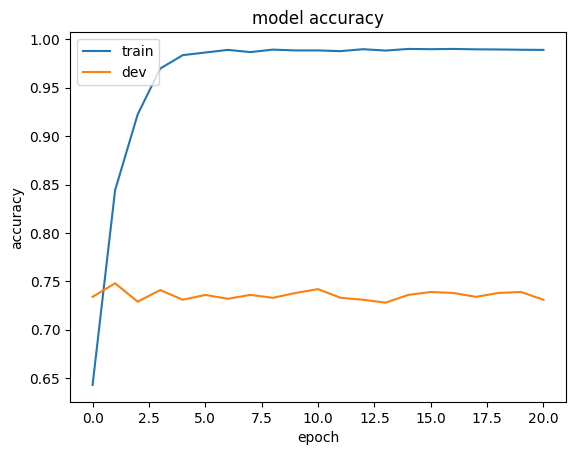

In [55]:
# summarize history for accuracy
plt.plot(history_val.history["categorical_accuracy"])
plt.plot(history_val.history["val_categorical_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "dev"], loc="upper left")
plt.show()

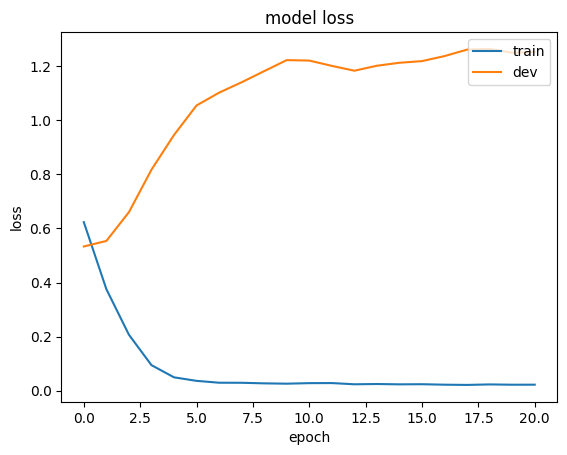

In [56]:
# summarize history for loss
plt.plot(history_val.history["loss"])
plt.plot(history_val.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "dev"], loc="upper right")
plt.show()

# Evaluate performance of the best-tuned model

In [57]:
# Predict class labels for the training data using the best model
predictions_train_tf_idf = np.argmax(best_model.predict(x_train_tfidf_new), -1)

# Predict class labels for the validation data
predictions_val_tf_idf = np.argmax(best_model.predict(x_val_tfidf_new), -1)

# Predict class labels for the test data
predictions_test_tf_idf = np.argmax(best_model.predict(x_test_tfidf_new), -1)

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [58]:
print("Classification Report for TRAIN data set:")
print(classification_report(y_train_new, predictions_train_tf_idf))

Classification Report for TRAIN data set:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3479
           1       0.99      0.99      0.99      3521

    accuracy                           0.99      7000
   macro avg       0.99      0.99      0.99      7000
weighted avg       0.99      0.99      0.99      7000



In [59]:
print("Classification Report for Validation data set:")
print(classification_report(y_val, predictions_val_tf_idf))

Classification Report for Validation data set:
              precision    recall  f1-score   support

           0       0.74      0.74      0.74       514
           1       0.72      0.72      0.72       486

    accuracy                           0.73      1000
   macro avg       0.73      0.73      0.73      1000
weighted avg       0.73      0.73      0.73      1000



In [60]:
print("Classification Report for TEST data set:")
print(classification_report(y_test, predictions_test_tf_idf))

Classification Report for TEST data set:
              precision    recall  f1-score   support

           0       0.72      0.73      0.72      1007
           1       0.72      0.72      0.72       993

    accuracy                           0.72      2000
   macro avg       0.72      0.72      0.72      2000
weighted avg       0.72      0.72      0.72      2000



# MLP with Centroids-Word Embedings

In [61]:
# Download and load Google news embeddings
wv = api.load("glove-twitter-100")

## Calculate centroids

In [62]:
# Define a function to calculate the centroid of a text document
def text_centroid(text, model):
    text = text.split()  # Split the text into individual words
    text_vec = []        # Initialize an empty list to store word vectors
    counter = 0          # Counter to keep track of valid words (non-stopwords)

    # Iterate through each word in the text
    for word in text:
        if word in STOP_WORDS:  # Skip stopwords (commonly used words that do not provide useful information)
            continue
        try:
            if counter == 0:
                # Get the word vector for the first valid word (in lowercase)
                text_vec = model[word.lower()]
            else:
                # Add the word vector for the current word to the running sum
                text_vec = np.add(text_vec, model[word.lower()])
            counter += 1  # Increment the valid word counter
        except:  # Skip words that are not in the model's vocabulary
            pass

    # If no valid words were found, return a zero vector
    if counter == 0:
        return np.zeros(model.vector_size)

    # Return the average of the word vectors (centroid) by dividing the sum by the counter
    return np.asarray(text_vec) / counter

In [63]:
# Calculate centroids for the training documents
X_train_centroids = []
for sentence in X_train_new:
    X_train_centroids.append(text_centroid(sentence, wv))  # Calculate the centroid for each sentence
X_train_centroids = np.stack(X_train_centroids, axis=0)    # Convert the list of centroids to a NumPy array

# Calculate centroids for the validation documents
X_val_centroids = []
for sentence in X_val:
    X_val_centroids.append(text_centroid(sentence, wv))     # Calculate centroids for validation data
X_val_centroids = np.stack(X_val_centroids, axis=0)         # Convert to a NumPy array

# Calculate centroids for the test documents
X_test_centroids = []
for sentence in x_test:
    X_test_centroids.append(text_centroid(sentence, wv))    # Calculate centroids for test data
X_test_centroids = np.stack(X_test_centroids, axis=0)       # Convert to a NumPy array

# MLP text classifier in Keras with centroid embeddings

In [64]:
# Define a new Sequential model
model2 = Sequential()

# Add the first dense (fully connected) layer with 1024 units and ReLU activation
# The input dimension is set to the number of features in the centroid vectors (X_train_centroids)
model2.add(Dense(1024, input_dim=X_train_centroids.shape[1], activation="relu"))

# Add a Dropout layer to reduce overfitting with a dropout rate of 0.3 (30% of neurons dropped)
model2.add(Dropout(0.3))

# Add a second dense layer with 1024 units and ReLU activation
model2.add(Dense(1024, activation="relu"))

# Add another Dropout layer with a 30% dropout rate
model2.add(Dropout(0.3))

# Add a third dense layer with 512 units and ReLU activation
model2.add(Dense(512, activation="relu"))

# Add another Dropout layer with a 30% dropout rate
model2.add(Dropout(0.3))

# Add the output layer with a softmax activation to classify into the number of unique classes
# The number of units in the output layer matches the number of unique classes in the target
model2.add(Dense(len(y_train_new.unique()), activation="softmax"))

# Print the model summary to display the structure and layers of the model
print(model2.summary())

# Compile the model with categorical cross-entropy as the loss function, Adam optimizer, and categorical accuracy metric
model2.compile(
    loss="categorical_crossentropy",            # Loss function for multi-class classification
    optimizer=Adam(learning_rate=0.001),        # Adam optimizer with a learning rate of 0.001
    metrics=[CategoricalAccuracy()],            # Use categorical accuracy as the evaluation metric
)

# Define an EarlyStopping callback to stop training if the validation loss doesn't improve for 20 epochs
early_stopping = EarlyStopping(patience=20, verbose=2, restore_best_weights=True)

# Train the model using the training centroid vectors and one-hot encoded labels
history2 = model2.fit(
    X_train_centroids,               # Training feature set (centroid vectors)
    y_train_1_hot,                   # Training labels (one-hot encoded)
    validation_data=(X_val_centroids, y_val_1_hot),  # Validation data (centroid vectors and labels)
    batch_size=256,                  # Batch size of 256
    epochs=100,                      # Maximum number of epochs to train
    shuffle=True,                    # Shuffle the training data at the start of each epoch
    callbacks=[
        Metrics(valid_data=(X_val_centroids, y_val_1_hot)),  # Custom metric callback for monitoring performance
        early_stopping,  # Apply early stopping to prevent overfitting and restore the best weights
    ],
)

/Users/antonal/ta2/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 1024)           │       103,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,678,850 (6.40 MB)

 Trainable params: 1,678,850 (6.40 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  - cate
 — val_f1: 0.786011 — val_precision: 0.786029 — val_recall: 0.786000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - categorical_accuracy: 0.6205 - loss: 0.6381 - val_categorical_accuracy: 0.7860 - val_loss: 0.4841 - val_f1: 0.7860 - val_recall: 0.7860 - val_precision: 0.7860
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/stepp - categ
 — val_f1: 0.792981 — val_precision: 0.792976 — val_recall: 0.793000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - categorical_accuracy: 0.7638 - loss: 0.4943 - val_categorical_accuracy: 0.7930 - val_loss: 0.4684 - val_f1: 0.7930 - val_recall: 0.7930 - val_precision: 0.7930
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
 — val_f1: 0.779818 — val_precision: 0.782949 — val_recall: 0.780000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - categorical_accuracy: 0.7721 - loss: 0.4745 - val_categorical_accuracy: 0.7800 - val_loss: 0.4716 - val_f1: 0.7798 - val_recall: 0.7800 - val_precision: 0.7829
Epoch 4/100


# Visualize Model's Training History

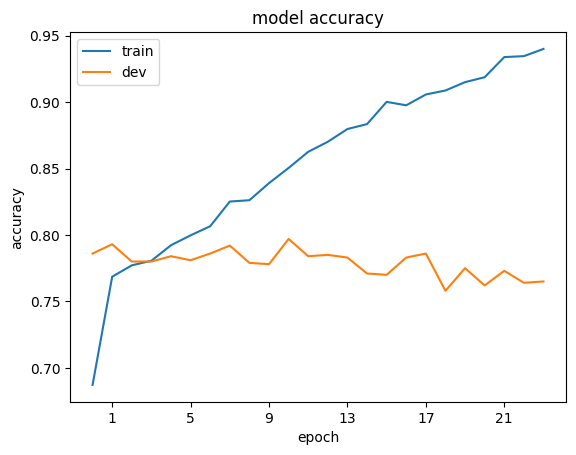

In [65]:
# summarize history for accuracy
plt.plot(history2.history["categorical_accuracy"])
plt.plot(history2.history["val_categorical_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "dev"], loc="upper left")
plt.xticks(range(1, len(history2.history["categorical_accuracy"]) + 1, 4))
plt.show()

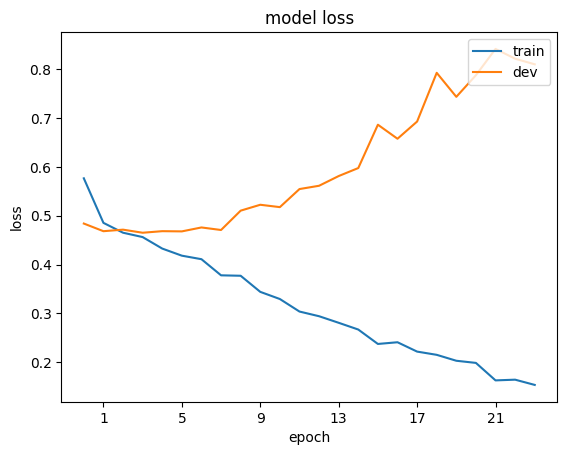

In [66]:
# summarize history for loss
plt.plot(history2.history["loss"])
plt.plot(history2.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "dev"], loc="upper right")
plt.xticks(range(1, len(history2.history["loss"]) + 1, 4))
plt.show()

In [69]:
# Save model & weights
model2.save("checkpoints/MLP_centroids.keras")

In [ ]:
# load weights and model from the saved checkpoint
centroids_model = load_model("checkpoints/MLP_centroids.keras")

In [70]:
# Predict the class labels for the test data using model2 (centroid-based model)
predictions = np.argmax(model2.predict(X_test_centroids), -1)

# Print a classification report comparing the true labels and predicted labels for the test set
print(classification_report(y_test, predictions))

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
              precision    recall  f1-score   support

           0       0.80      0.75      0.77      1007
           1       0.76      0.81      0.78       993

    accuracy                           0.78      2000
   macro avg       0.78      0.78      0.78      2000
weighted avg       0.78      0.78      0.78      2000



/Users/antonal/ta2/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [71]:
# Set training data and class labels for hyperparameter tuning
xtrain = X_train_centroids
classes = y_train_new.unique()

# Lambda function to build the model with hyperparameters provided by the tuner
build_model_with_params = lambda hp: build_model(hp, xtrain, classes)

# Initialize a RandomSearch tuner to find the best hyperparameters for the centroid-based model
tuner = kt.RandomSearch(
    build_model_with_params,                               # Model-building function
    objective=kt.Objective("val_categorical_accuracy", direction="max"),  # Objective to maximize validation accuracy
    max_trials=20,                                         # Number of trials to run
    directory="KT_dir_2",                                  # Directory to save results
    project_name="KT_tuning",                              # Project name for tracking
)

# Early stopping callback to stop tuning if validation loss doesn't improve for 20 epochs
early_stopping = EarlyStopping(monitor="val_loss", patience=20)

# Display a summary of the search space (hyperparameters being tuned)
tuner.search_space_summary()

Search space summary
Default search space size: 5
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
hidden_units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 512, 'step': 64, 'sampling': 'linear'}
activation_layer0 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout_layer_0 (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.2, 0.3, 0.4, 0.5], 'ordered': True}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0001], 'ordered': True}


/Users/antonal/ta2/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [72]:
# Start the search for the best hyperparameters using the training and validation data
tuner.search(
    X_train_centroids,                                    # Training feature set (centroids)
    y_train_1_hot,                                        # Training labels (one-hot encoded)
    validation_data=(X_val_centroids, y_val_1_hot),       # Validation data (centroids and labels)
    epochs=50,                                            # Number of epochs to train during search
    batch_size=128,                                       # Batch size
    callbacks=[early_stopping],                           # Use early stopping
)

Trial 20 Complete [00h 00m 08s]
val_categorical_accuracy: 0.7860000133514404

Best val_categorical_accuracy So Far: 0.8009999990463257
Total elapsed time: 00h 01m 34s


In [73]:
# Created checkpoints and configuration files
!ls KT_dir_2/KT_tuning
!ls KT_dir_2/KT_tuning/trial_00

oracle.json trial_03    trial_07    trial_11    trial_15    trial_19
trial_00    trial_04    trial_08    trial_12    trial_16    tuner0.json
trial_01    trial_05    trial_09    trial_13    trial_17
trial_02    trial_06    trial_10    trial_14    trial_18
build_config.json     checkpoint.weights.h5 trial.json


In [74]:
# Trials summary
tuner.results_summary()

Results summary
Results in KT_dir_2/KT_tuning
Showing 10 best trials
Objective(name="val_categorical_accuracy", direction="max")

Trial 11 summary
Hyperparameters:
num_layers: 3
hidden_units_0: 128
activation_layer0: tanh
dropout_layer_0: 0.2
learning_rate: 0.001
hidden_units_1: 448
activation_layer1: relu
dropout_layer_1: 0.2
hidden_units_2: 448
activation_layer2: relu
dropout_layer_2: 0.1
Score: 0.8009999990463257

Trial 04 summary
Hyperparameters:
num_layers: 2
hidden_units_0: 384
activation_layer0: relu
dropout_layer_0: 0.4
learning_rate: 0.001
hidden_units_1: 448
activation_layer1: relu
dropout_layer_1: 0.2
hidden_units_2: 256
activation_layer2: relu
dropout_layer_2: 0.1
Score: 0.800000011920929

Trial 00 summary
Hyperparameters:
num_layers: 1
hidden_units_0: 128
activation_layer0: relu
dropout_layer_0: 0.4
learning_rate: 0.0001
Score: 0.7960000038146973

Trial 10 summary
Hyperparameters:
num_layers: 1
hidden_units_0: 192
activation_layer0: relu
dropout_layer_0: 0.2
learning_rate:

In [75]:
# Get best hyper-parameters setup
tuner.get_best_hyperparameters()[0].values

{'num_layers': 3,
 'hidden_units_0': 128,
 'activation_layer0': 'tanh',
 'dropout_layer_0': 0.2,
 'learning_rate': 0.001,
 'hidden_units_1': 448,
 'activation_layer1': 'relu',
 'dropout_layer_1': 0.2,
 'hidden_units_2': 448,
 'activation_layer2': 'relu',
 'dropout_layer_2': 0.1}

In [76]:
# Retrieve the best model from the hyperparameter search
best_model_2 = tuner.get_best_models(num_models=1)[0]

# Display a summary of the best model's architecture and layers
best_model_2.summary()

/Users/antonal/ta2/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/antonal/ta2/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        12,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 448)            │        57,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 448)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 448)            │       201,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 448)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           898 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 272,770 (1.04 MB)

 Trainable params: 272,770 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Predict class labels for the training data using the best model
predictions_train_centroid = np.argmax(best_model_2.predict(X_train_centroids), -1)

# Predict class labels for the validation data
predictions_val_centroid = np.argmax(best_model_2.predict(X_val_centroids), -1)

# Predict class labels for the test data
predictions_test_centroid = np.argmax(best_model_2.predict(X_test_centroids), -1)

In [77]:
print("Classification Report for TRAIN data set:")
print(classification_report(y_train_new, predictions_train_centroid))

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step
Classification Report for TRAIN data set:
              precision    recall  f1-score   support

           0       0.86      0.85      0.86      3479
           1       0.86      0.87      0.86      3521

    accuracy                           0.86      7000
   macro avg       0.86      0.86      0.86      7000
weighted avg       0.86      0.86      0.86      7000



In [78]:
print("Classification Report for Validation data set:")
print(classification_report(y_val, predictions_val_centroid))

Classification Report for Validation data set:
              precision    recall  f1-score   support

           0       0.81      0.79      0.80       514
           1       0.79      0.81      0.80       486

    accuracy                           0.80      1000
   macro avg       0.80      0.80      0.80      1000
weighted avg       0.80      0.80      0.80      1000



In [79]:
print("Classification Report for TEST data set:")
print(classification_report(y_test, predictions_test_centroid))

Classification Report for TEST data set:
              precision    recall  f1-score   support

           0       0.78      0.78      0.78      1007
           1       0.78      0.78      0.78       993

    accuracy                           0.78      2000
   macro avg       0.78      0.78      0.78      2000
weighted avg       0.78      0.78      0.78      2000



In [80]:
# Fine-tune the best model using the training centroid vectors and one-hot encoded labels
history_val_2 = best_model_2.fit(
    X_train_centroids,                                    # Training feature set (centroid vectors)
    y_train_1_hot,                                        # Training labels (one-hot encoded)
    validation_data=(X_val_centroids, y_val_1_hot),       # Validation data
    batch_size=256,                                       # Batch size
    epochs=100,                                           # Maximum number of epochs
    shuffle=True,                                         # Shuffle the training data at the start of each epoch
    callbacks=[
        Metrics(valid_data=(X_val_centroids, y_val_1_hot)),  # Custom metric callback for monitoring
        checkpoint,                                         # Save the best model
        early_stopping,                                     # Early stopping to prevent overfitting
    ],
)

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step categ
 — val_f1: 0.784042 — val_precision: 0.784392 — val_recall: 0.784000

Epoch 1: val_f1 improved from 0.74947 to 0.78404, saving model to checkpoints/mlp.weights.h5
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - categorical_accuracy: 0.8344 - loss: 0.3563 - val_categorical_accuracy: 0.7840 - val_loss: 0.5112 - val_f1: 0.7840 - val_recall: 0.7840 - val_precision: 0.7844
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step catego
 — val_f1: 0.778040 — val_precision: 0.778584 — val_recall: 0.778000

Epoch 2: val_f1 did not improve from 0.78404
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.8435 - loss: 0.3510 - val_categorical_accuracy: 0.7780 - val_loss: 0.5137 - val_f1: 0.7780 - val_recall: 0.7780 - val_precision: 0.7786
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step catego
 — val_f1: 0.774146 — val_precision: 0.777056 — val_recall: 0.775000

Epoch 3: val_f1 did not improve from 0.78404
28/28 ━━━━━━━━━━━━━━━━━━━━

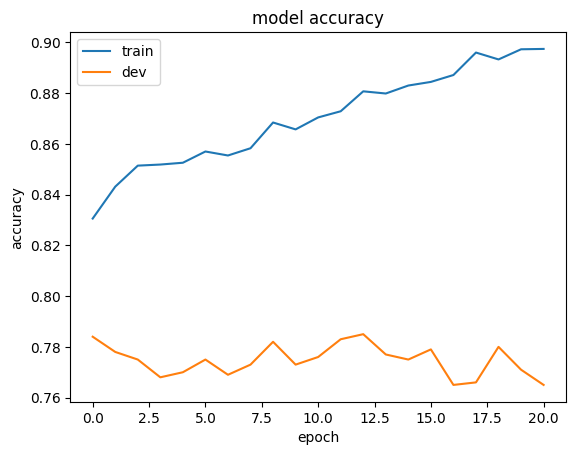

In [81]:
# summarize history for accuracy
plt.plot(history_val_2.history["categorical_accuracy"])
plt.plot(history_val_2.history["val_categorical_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "dev"], loc="upper left")
plt.show()

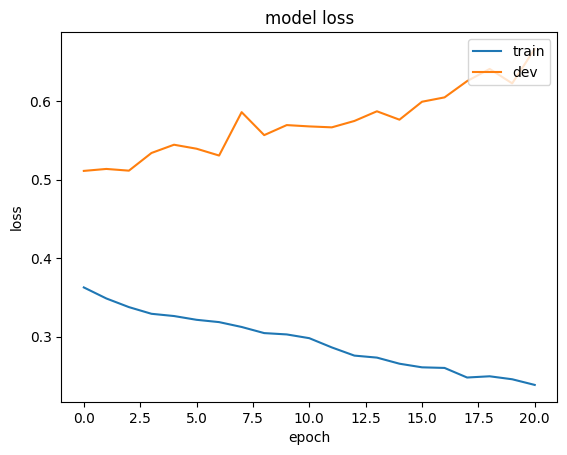

In [82]:
# summarize history for loss
plt.plot(history_val_2.history["loss"])
plt.plot(history_val_2.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "dev"], loc="upper right")
plt.show()

# Precision-Recall curves

In [ ]:
# Disable warnings for large floating-point numbers in estimated probabilities
np.seterr(all="ignore")

In [ ]:
# Precision-Recall curve for Logistic Regression with TF-IDF features
name = "Tuned Logistic Regression Tf-Idf"
model = log_cv  # Use pre-tuned logistic regression model
model.fit(x_train_tfidf, y_train)  # Fit the model to the TF-IDF training data
pred = model.predict_proba(x_test_tfidf)  # Get predicted probabilities for the test data
precision, recall, thresholds = precision_recall_curve(y_test, pred[:, 1])  # Calculate precision and recall
area = auc(recall, precision)  # Calculate the area under the precision-recall curve

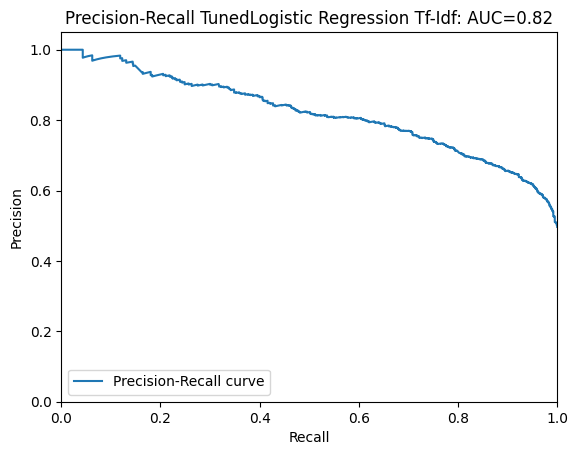

In [87]:
plt.plot(recall, precision, label="Precision-Recall curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title("Precision-Recall %s: AUC=%0.2f" % (name, area))
plt.legend(loc="lower left")
plt.show()

In [ ]:
# Precision-Recall curve for MLP with TF-IDF features
name = "MLP Tf-Idf"
model = best_model  # Use the best MLP model (with TF-IDF features)
pred = predictions_test_tf_idf  # Predicted class labels for the test data
precision, recall, thresholds = precision_recall_curve(y_test, pred)  # Calculate precision and recall
area = auc(recall, precision)  # Calculate the area under the precision-recall curve

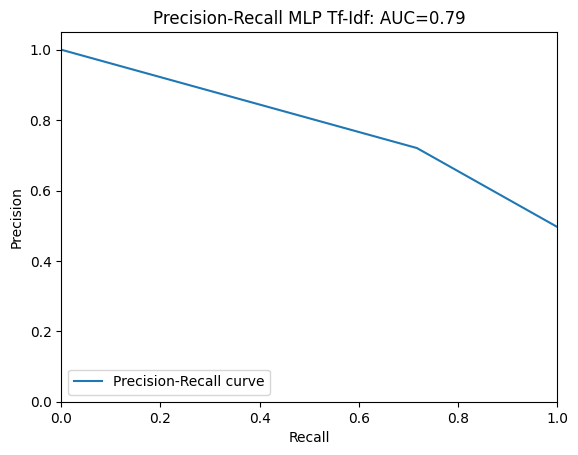

In [88]:
plt.plot(recall, precision, label="Precision-Recall curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title("Precision-Recall %s: AUC=%0.2f" % (name, area))
plt.legend(loc="lower left")
plt.show()

In [ ]:
# Precision-Recall curve for MLP with centroid features
name = "MLP With Centroid"
model = best_model_2  # Use the best MLP model (with centroid features)
pred = predictions_test_centroid  # Predicted class labels for the test data
precision, recall, thresholds = precision_recall_curve(y_test, pred)  # Calculate precision and recall
area = auc(recall, precision)  # Calculate the area under the precision-recall curve

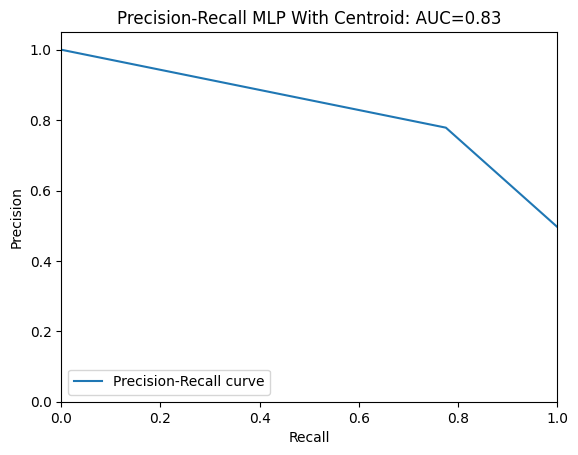

In [89]:
plt.plot(recall, precision, label="Precision-Recall curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title("Precision-Recall %s: AUC=%0.2f" % (name, area))
plt.legend(loc="lower left")
plt.show()